In [36]:
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [37]:
# read the pickle file
with open('../tracker_stubs/ball_detection.pkl', 'rb') as f:
    ball_positions = pickle.load(f)

In [38]:
ball_positions =[x.get(1,[]) for x in ball_positions]
# covert the list of lists to a dataframe
df_ball_positions =pd.DataFrame(ball_positions,columns=['x1','y1','x2','y2'])

# interpolate the missing values in the dataframe
df_ball_positions = df_ball_positions.interpolate(method='linear', axis=0)
df_ball_positions = df_ball_positions.bfill() # backfill the missing values

In [39]:
df_ball_positions['mid_y'] = (df_ball_positions['y1'] + df_ball_positions['y2']) / 2
df_ball_positions['mid_y_rolling_mean'] = df_ball_positions['mid_y'].rolling(window=5, min_periods=1, center=False).mean()

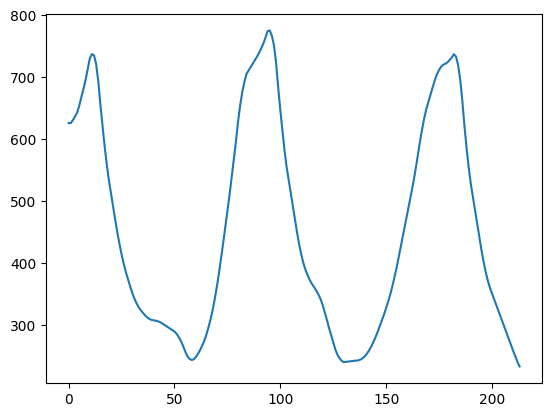

In [40]:
#plot mid_y_rolling_mean
plt.plot(df_ball_positions['mid_y_rolling_mean'])

In [41]:
#計算 mid_y_rolling_mean 欄位的相鄰元素之間的差異，並將結果存儲到新的欄位 delta_y 中。
df_ball_positions['delta_y'] = df_ball_positions['mid_y_rolling_mean'].diff()

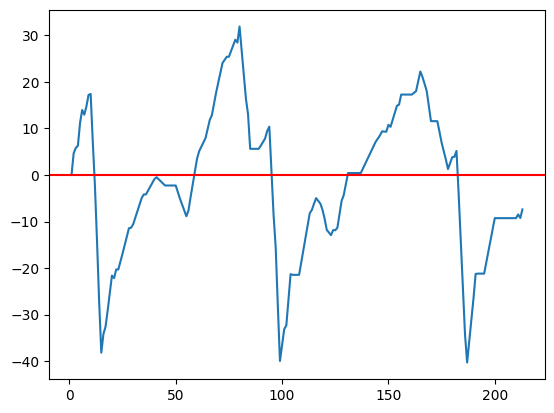

In [42]:
#plot mid_y_rolling_mean
plt.plot(df_ball_positions['delta_y'])
# plot line over the 0
plt.axhline(y=0, color='r', linestyle='-')

In [43]:
df_ball_positions['ball_hit']=0

In [44]:
minimum_change_frames_for_hit = 25  # 定義判斷球被擊中所需的最小變化幀數

# 遍歷每一個幀，檢查球是否被擊中
for i in range(1, len(df_ball_positions) - int(minimum_change_frames_for_hit * 1.2)):
    # 檢查相鄰幀中的位置變化是否符合球被擊中的情況
    negative_positions_change = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[i + 1] < 0
    positive_positions_change = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[i + 1] > 0
    
    # 如果發現符合擊中條件的變化，進一步檢查接下來的幾個幀是否還存在相同的變化模式
    if negative_positions_change or positive_positions_change:
        
        change_count = 0
        for change_frame in range(i + 1, i + int(minimum_change_frames_for_hit * 1.2) + 1):
            # 檢查接下來的幾個幀中位置變化是否符合球被擊中的情況，並統計變化的幀數
            negative_positions_change_following_frame = df_ball_positions['delta_y'].iloc[i] > 0 and df_ball_positions['delta_y'].iloc[change_frame] < 0
            positive_positions_change_following_frame = df_ball_positions['delta_y'].iloc[i] < 0 and df_ball_positions['delta_y'].iloc[change_frame] > 0

            if negative_positions_change and negative_positions_change_following_frame:
                change_count += 1
            elif positive_positions_change and positive_positions_change_following_frame:
                change_count += 1

        # 如果連續幀數超過了 minimum_change_frames_for_hit - 1，則標記球被擊中
        if change_count > minimum_change_frames_for_hit - 1:
            df_ball_positions['ball_hit'].loc[i] = 1


C:\Users\fishd\AppData\Local\Temp\ipykernel_40584\3593705193.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_ball_positions['ball_hit'].loc[i] = 1


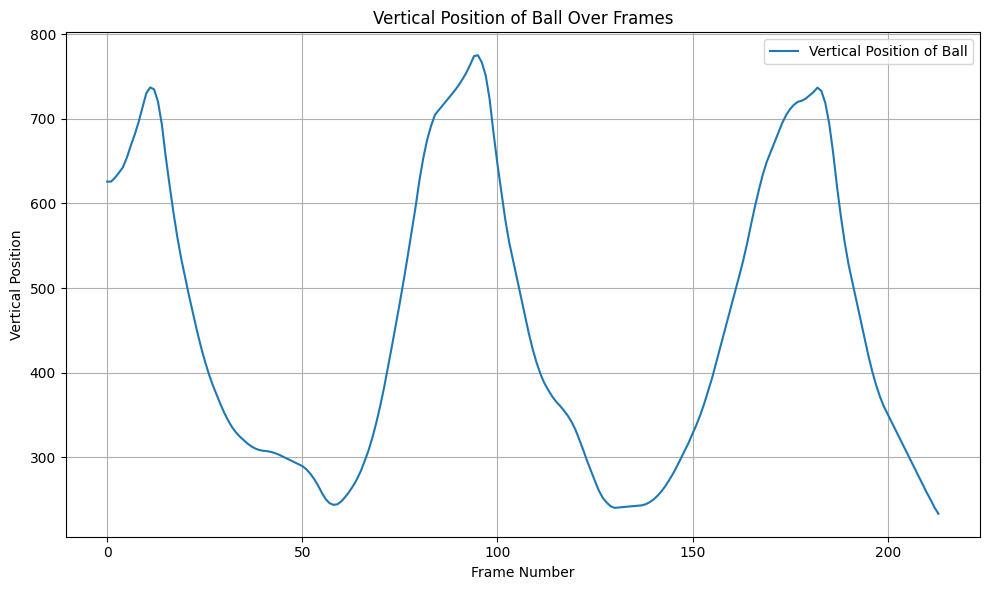

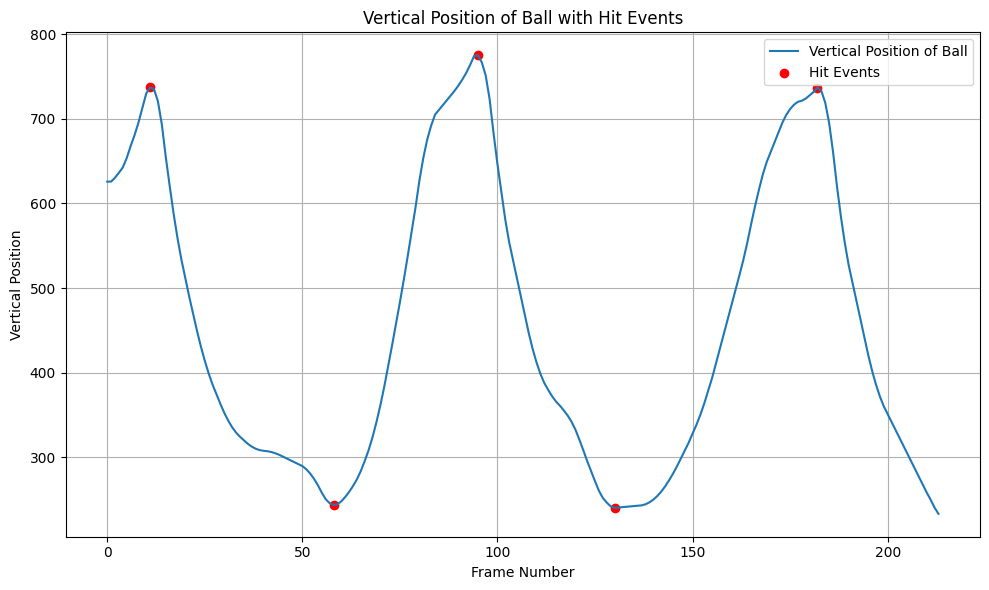

In [45]:
import matplotlib.pyplot as plt

# 視覺化球的垂直位置
plt.figure(figsize=(10, 6))
plt.plot(df_ball_positions.index, df_ball_positions['mid_y_rolling_mean'], label='Vertical Position of Ball')
plt.xlabel('Frame Number')
plt.ylabel('Vertical Position')
plt.title('Vertical Position of Ball Over Frames')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# 視覺化標記為擊中的事件
plt.figure(figsize=(10, 6))
plt.plot(df_ball_positions.index, df_ball_positions['mid_y_rolling_mean'], label='Vertical Position of Ball')
plt.scatter(df_ball_positions.index[df_ball_positions['ball_hit'] == 1], 
            df_ball_positions['mid_y_rolling_mean'][df_ball_positions['ball_hit'] == 1], 
            color='red', label='Hit Events')
plt.xlabel('Frame Number')
plt.ylabel('Vertical Position')
plt.title('Vertical Position of Ball with Hit Events')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


In [46]:
df_ball_positions[df_ball_positions['ball_hit']==1]

,x1,y1,x2,y2,mid_y,mid_y_rolling_mean,delta_y,ball_hit
11,776.709452,720.312073,796.989604,742.088725,731.200399,737.196751,7.098912,1
58,926.004456,241.682980,938.173718,254.228882,247.955931,243.722991,-1.972480,1
95,622.714264,748.194336,641.872894,768.230286,758.212311,775.198712,0.964386,1
130,714.360218,234.492537,727.567194,247.574682,241.033610,240.180738,-1.934572,1
182,1295.260132,740.060669,1314.511475,759.126160,749.593414,736.930988,5.181470,1


In [47]:
frame_nums_with_ball_hit = df_ball_positions[df_ball_positions['ball_hit']==1].index.tolist()
frame_nums_with_ball_hit

[11, 58, 95, 130, 182]